# Running and Plotting Coeval Cubes

In [1]:
%matplotlib inline

import py21cmmc as p21c

# For plotting the cubes, we use the plotting submodule:
from py21cmmc import plotting

In [2]:
print(f"Using 21CMMC version {p21c.__version__}")

Using 21CMMC version 0.1.0


The aim of this tutorial is to introduce you to how 21CMMC does the most basic operations: producing single coeval cubes, and visually verifying them. It is a great place to get started with 21CMMC.

Clear the cache so that we get the same results for the notebook every time (don't worry about this for now):

In [3]:
#from py21cmmc.cli import _query
#_query(clear=True)

### Step-by-Step Method

21CMMC allows several methods of generating full coeval brightness temperature cubes. The most detailed method is to do the calculation step-by-step, so that each step can be stored and examined. We show this method first to illustrate the several steps in the process.

Each step in this chain will receive a number of input-parameter classes which define how the calculation should run (technically each of these classes are subclasses of the ``StructWithDefaults`` class, but you don't really have to worry about that). Importantly, each of these classes is something like a dictionary (with extra methods for passing their values to the underlying C code), but it has a default for each parameter such that they can be entirely ignored if you want.

Conversely, each step is performed by running a function which will return a single object, which is a subclass of ``OutputStruct``. Again, these are just convenient ways to group the various arrays that are defined at each step, with methods for passing them between the C and Python code (which you don't have to worry about). Importantly, these classes also have methods for permanently storing the data to your disk cache, and automatically reading it back in. They also store references to the input parameters which define the data, and these are used to validate that a cached dataset is representative of the desired parameters. 

Lets trace each step. First we get the initial conditions, which defines the *cosmological* density field before any redshift evolution is applied.

In [4]:
initial_conditions = p21c.initial_conditions(
    user_params = {"HII_DIM": 100, "BOX_LEN": 100},
    cosmo_params = p21c.CosmoParams(SIGMA_8=0.8)
)

Here we pause and note a few things: first, the ``user_params`` and ``cosmo_params`` are instances of the ``StructWithDefaults`` that we mentioned previously. These initial conditions have 100 cells per side, and a box length of 100 Mpc. Note however that there are two ways to define them. They can be passed as a dictionary containing the input parameters, or an actual instance of the class. The benefit of the latter is that it can be queried for the relevant parameters (by using ``help`` or a post-fixed ``?``), or even queried for defaults:

In [5]:
p21c.CosmoParams._defaults_

{'RANDOM_SEED': None,
 'SIGMA_8': 0.82,
 'hlittle': 0.6774,
 'OMm': 0.3075,
 'OMb': 0.0486,
 'POWER_INDEX': 0.97}

(these defaults correspond to the Planck15 cosmology contained in Astropy). So what is in the ``initial_conditions`` object? It contains a number of arrays specifying the density and velocity fields of our initial conditions, as well as the defining parameters. For example, we can easily show the cosmology parameters that are used (note the non-default $\sigma_8$):

In [6]:
initial_conditions.cosmo_params

CosmoParams(OMb:0.0486, OMm:0.3075, POWER_INDEX:0.97, SIGMA_8:0.8, hlittle:0.6774)

A handy tip is that the ``CosmoParams`` class also has a reference to a corresponding Astropy cosmology, which can be used more broadly:

In [7]:
initial_conditions.cosmo_params.cosmo

FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)

Merely printing the initial conditions object gives a useful representation of its dependent parameters:

In [8]:
print(initial_conditions)

InitialConditions(UserParams(BOX_LEN:100, DIM:400, HII_DIM:100, USE_FFTW_WISDOM:False);
	 CosmoParams(OMb:0.0486, OMm:0.3075, POWER_INDEX:0.97, SIGMA_8:0.8, hlittle:0.6774))


(side-note: the string representation of the object is used to uniquely define it in order to save it to the cache... which we'll explore soon!).

To see which arrays are defined in the object, access the ``fieldnames``:

In [9]:
initial_conditions.fieldnames

['lowres_density',
 'lowres_vx',
 'lowres_vy',
 'lowres_vz',
 'lowres_vx_2LPT',
 'lowres_vy_2LPT',
 'lowres_vz_2LPT',
 'hires_density']

We can use a generic but handy visualisation tool to view the density field. It takes the object, and a specific field name. Let's use the hires density:

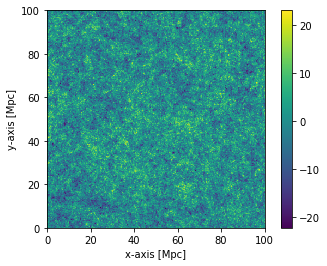

In [10]:
plotting.coeval_sliceplot(initial_conditions, "hires_density");

After obtaining the initial conditions, we need to *perturb* the field to a given redshift (i.e. the redshift we care about). This step clearly requires the results of the previous step, which can easily just pass in. Let's do that:

In [11]:
perturbed_field = p21c.perturb_field(
    redshift = 8.0,
    init_boxes = initial_conditions
)

Again, the output is an output struct, so we can view its fields:

In [ ]:
perturbed_field.fieldnames

['density', 'velocity']

This time, it has only density and velocity (the velocity direction is chosen without loss of generality). Let's view the perturbed density field:

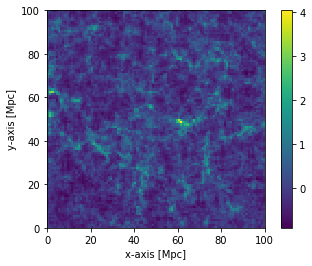

In [ ]:
plotting.coeval_sliceplot(perturbed_field, "density");

It is clear here that the density used is the *low*-res density, but the overall structure of the field looks very similar.

Next, we need to ionize the box. This is where things get a little more tricky. In the simplest case (which, let's be clear, is what we're going to do here) the ionization occurs at the *saturated limit*, which means we can safely ignore the contribution of the spin temperature. This means we can directly calculate the ionization on the density/velocity fields that we already have. A few more parameters are needed here, and so two more "input parameter dictionaries" are available, ``astro_params`` and ``flag_options``. Let's see their parameters/defaults (you can get a better explanation of each parameter in the API docs, or by calling ``help``):

In [ ]:
p21c.AstroParams._defaults_

{'EFF_FACTOR_PL_INDEX': 0.0,
 'HII_EFF_FACTOR': 30.0,
 'R_BUBBLE_MAX': None,
 'ION_Tvir_MIN': 4.69897,
 'L_X': 40.0,
 'NU_X_THRESH': 500.0,
 'X_RAY_SPEC_INDEX': 1.0,
 'X_RAY_Tvir_MIN': None,
 'F_STAR': 0.05,
 't_STAR': 0.5,
 'N_RSD_STEPS': 20}

In [ ]:
p21c.FlagOptions._defaults_

{'USE_MASS_DEPENDENT_ZETA': False,
 'SUBCELL_RSD': False,
 'INHOMO_RECO': False,
 'USE_TS_FLUCT': False}

For now, let's leave everything as default. In that case, we can just do:

In [ ]:
ionized_field = p21c.ionize_box(
    perturbed_field = perturbed_field
)

Existing init_boxes found and read in.


That was easy! All the information required by ``ionize_box`` was given directly by the ``perturbed_field`` object. In fact, even if we had passed a different redshift, the redshift in ``perturbed_field`` would have over-ridden it (silently, beware!). 

Let's see the fieldnames:

In [ ]:
ionized_field.fieldnames

['first_box', 'xH_box', 'Gamma12_box', 'z_re_box', 'dNrec_box']

Here the ``first_box`` field is actually just a flag to tell the C code whether this has been *evolved* or not. Here, it hasn't been, it's the "first box" of an evolutionary chain. Let's plot the neutral fraction:

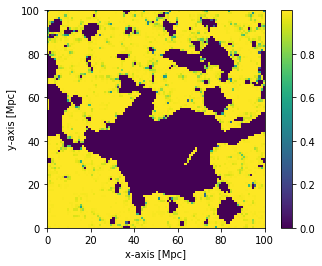

In [ ]:
plotting.coeval_sliceplot(ionized_field, "xH_box");

Now we can use what we have to get the brightness temperature:

In [ ]:
brightness_temp = p21c.brightness_temperature(ionized_box=ionized_field, perturb_field=perturbed_field)

This has only a single field, ``brightness_temp``:

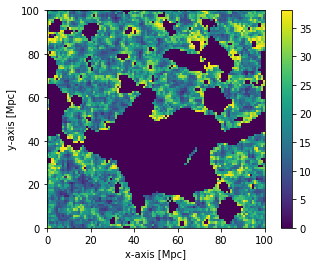

In [ ]:
plotting.coeval_sliceplot(brightness_temp);

Here we used a nifty feature of the ``coeval_sliceplot`` function: if no ``kind`` argument is given, it uses the first (in this case, only) field in the fieldnames list.

### Using the Automatic Cache

Oftentimes, you might want the perturbed field, but don't care about keeping the initial conditions. You could, of course, call the ``initial_conditions`` function and save the result to a temporary variable (or better, call it *within* the call to ``perturb_field``), but that's just a lot of boilerplate. Plus, those ``initial_conditions`` can take a long time to run. You don't want to have to run the same ones twice. 

To solve all this, ``21CMMC`` uses an on-disk caching mechanism, where all boxes are saved in HDF5 format in a default location. The cache has a format which is difficult to interpret except by using ``21CMMC``, but it allows for reading in previously-calculated boxes automatically if they match the parameters that are input. The functions used at every step (in the previous section) will try to use a cached box instead of calculating a new one, unless its explicitly asked *not* to. 

Thus, we could do this:

In [ ]:
perturbed_field = p21c.perturb_field(
    redshift = 8.0,
    user_params = {"HII_DIM": 100, "BOX_LEN": 100},
    cosmo_params = p21c.CosmoParams(SIGMA_8=0.8)
)

Existing z=8.0 perturb_field boxes found and read in.


Note that here we pass exactly the same parameters as were used in the previous section. It gives a message that the full box was found in the cache and immediately returns. However, if we change the redshift:

In [ ]:
perturbed_field = p21c.perturb_field(
    redshift = 7.0,
    user_params = {"HII_DIM": 100, "BOX_LEN": 100},
    cosmo_params = p21c.CosmoParams(SIGMA_8=0.8)
)

Existing z=7.0 perturb_field boxes found and read in.


Now it finds the initial conditions, but it must compute the perturbed field at the new redshift. If we had changed the initial parameters as well, it would have to calculate everything:

In [ ]:
perturbed_field = p21c.perturb_field(
    redshift = 8.0,
    user_params = {"HII_DIM": 50, "BOX_LEN": 100},
    cosmo_params = p21c.CosmoParams(SIGMA_8=0.8)
)

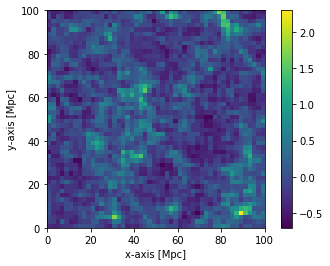

In [ ]:
plotting.coeval_sliceplot(perturbed_field);

This shows that we don't need to perform the *previous* step to do any of the steps, they will be calculated automatically.

Now, let's get an ionized box, but this time we won't assume the saturated limit, so we need to use the spin temperature. We can do this directly in the ionize_box function, but let's do it explicitly. We will use the auto-generation of the initial conditions and perturb field. However, the spin temperature is an *evolved* field, i.e. to compute the field at $z$, we need to know the field at $z+\Delta z$. This continues up to some redshift, labelled ``z_heat_max``, above which the spin temperature can be defined directly from the perturbed field. 

Thus, one option is to pass to the function a *previous* spin temperature box, to evolve to *this* redshift. However, we don't have a previous spin temperature box yet. Of course, the function itself will go and calculate that box if it's not given (or read it from cache if it's been calculated before!). When it tries to do that, it will go to the one before, and so on until it reaches ``z_heat_max``, at which point it will calculate it directly. 

To facilitate this recursive progression up the redshift ladder, there is a parameter, ``z_step_factor``, which is a multiplicate factor that determines the previous redshift at each step. 

We can also pass the dependent boxes explicitly, which provides the parameters necessary.

**WARNING: THIS IS THE MOST TIME-CONSUMING STEP OF THE CALCULATION!**

In [ ]:
spin_temp = p21c.spin_temperature(
    perturbed_field = perturbed_field,
    z_step_factor=1.05
)

Existing init_boxes found and read in.


In [ ]:
spin_temp.fieldnames

['first_box', 'Ts_box', 'x_e_box', 'Tk_box']

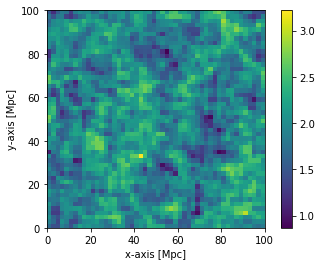

In [ ]:
plotting.coeval_sliceplot(spin_temp, "Ts_box");

Let's note here that each of the functions accepts a few of the same arguments that modifies how the boxes are cached. There is a ``write`` argument, which if set to ``False``, will disable writing that box to cache (and it is passed through the recursive heirarchy). There is also ``regenerate``, which if ``True``, forces this box and all its predecessors to be re-calculated even if they exist in the cache. There is is ``direc``, which changes the directory to which the cache files will be written (and read); we recommend only changing this if necessary. Finally there is ``match_seed``: the assumption is usually that the user does not care about which random seed generated the simulation. So if a seed is set (in the CosmoParams), but a simulation of the same parameters but different seed is found, then it will be read in (and the seed will be reset accordingly). Of course, one has to be a bit careful, the seed for the perturbed field must match the seed for the initial conditions for them to be used together to create the ionized box. These consistency checks are all done within the functions so you don't have to worry.

Now if calculate the ionized box, ensuring that it uses the spin temperature, then it will also need to be evolved. However, due to the fact that we cached each of the spin temperature steps, these should be read in accordingly:

In [ ]:
ionized_box = p21c.ionize_box(
    spin_temp = spin_temp,
    z_step_factor=1.05
)

Existing init_boxes found and read in.
Existing z=34.2811622461279 perturb_field boxes found and read in.
Existing z=34.2811622461279 spin_temp boxes found and read in.
Existing z=32.60110690107419 perturb_field boxes found and read in.
Existing z=32.60110690107419 spin_temp boxes found and read in.
Existing z=31.00105419149923 perturb_field boxes found and read in.
Existing z=31.00105419149923 spin_temp boxes found and read in.
Existing z=29.4771944680945 perturb_field boxes found and read in.
Existing z=29.4771944680945 spin_temp boxes found and read in.
Existing z=28.02589949342333 perturb_field boxes found and read in.
Existing z=28.02589949342333 spin_temp boxes found and read in.
Existing z=26.643713803260315 perturb_field boxes found and read in.
Existing z=26.643713803260315 spin_temp boxes found and read in.
Existing z=25.32734647929554 perturb_field boxes found and read in.
Existing z=25.32734647929554 spin_temp boxes found and read in.
Existing z=24.073663313614798 perturb_f

Great! So again, we can just get the brightness temp:

In [ ]:
brightness_temp = p21c.brightness_temperature(
    ionized_box = ionized_box,
    perturb_field = perturbed_field,
    spin_temp = spin_temp
)

Now lets plot our brightness temperature, which has been evolved from high redshift with spin temperature fluctuations:

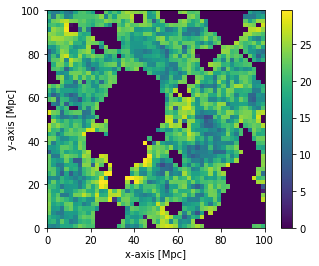

In [ ]:
plotting.coeval_sliceplot(brightness_temp);

We can also check what the result would have been if we had limited the maximum redshift of heating:

Existing init_boxes found and read in.
Existing init_boxes found and read in.
Existing z=19.62816486020931 spin_temp boxes found and read in.
Existing init_boxes found and read in.
Existing z=18.645871295437438 spin_temp boxes found and read in.
Existing init_boxes found and read in.
Existing z=17.71035361470232 spin_temp boxes found and read in.
Existing init_boxes found and read in.
Existing z=16.81938439495459 spin_temp boxes found and read in.
Existing init_boxes found and read in.
Existing z=15.970842280909132 spin_temp boxes found and read in.
Existing init_boxes found and read in.
Existing z=15.162706934199171 spin_temp boxes found and read in.
Existing init_boxes found and read in.
Existing z=14.393054223046828 spin_temp boxes found and read in.
Existing init_boxes found and read in.
Existing z=13.66005164099698 spin_temp boxes found and read in.
Existing init_boxes found and read in.
Existing z=12.961953943806646 spin_temp boxes found and read in.
Existing init_boxes found and

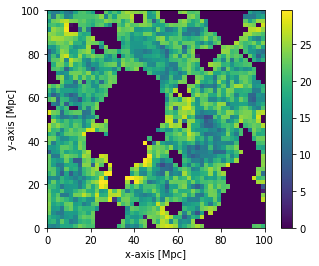

In [ ]:
ionized_box = p21c.ionize_box(
    spin_temp = spin_temp,
    z_step_factor=1.05,
    z_heat_max = 20.0
)

brightness_temp = p21c.brightness_temperature(
    ionized_box = ionized_box,
    perturb_field = perturbed_field,
    spin_temp = spin_temp
)

plotting.coeval_sliceplot(brightness_temp);

As we can see, it's very similar!

### The easy way

The two previous methods are very flexible, but come at the cost of a bit of conceptual overhead, as well as not being perfectly efficient (the recursive approach means that some data is kept in memory when it wouldn't have to if the evolution was done procedurally). That's why ``21CMMC`` also provides the convenient ``run_coeval`` function. Internally, this function uses the ones we've already used, but it is able to decide on which bits to keep in memory and and runs forward, thus making it a little more efficient.

It returns the results of all four steps. Conveniently, one can pass more than one redshift to evaluate, and the results will be a list of these redshifts. If the cube requires redshift evolution, only the redshifts that are passed to the function will be returned (but the others will of course be cached!). 

In [3]:
init, perturb, ionize, brightness_temp = p21c.run_coeval(
    redshift = [8.0, 9.0, 10.0],
    #init_box = initial_conditions, # This provides all the parameters. We could have passed cosmo_params + user_params
    user_params = {"HII_DIM":50, "BOX_LEN":100},
    z_step_factor = 1.05,
    do_spin_temp = True
)

Existing init_boxes found and read in.
Existing z=34.99602400563593 perturb_field boxes found and read in.
Existing z=34.99602400563593 spin_temp boxes found and read in.
Existing z=34.290219613368556 perturb_field boxes found and read in.
Existing z=34.290219613368556 spin_temp boxes found and read in.
Existing z=33.59825452291035 perturb_field boxes found and read in.
Existing z=33.59825452291035 spin_temp boxes found and read in.
Existing z=32.91985737540231 perturb_field boxes found and read in.
Existing z=32.91985737540231 spin_temp boxes found and read in.
Existing z=32.25476213274736 perturb_field boxes found and read in.
Existing z=32.25476213274736 spin_temp boxes found and read in.
Existing z=31.602707973281724 perturb_field boxes found and read in.
Existing z=31.602707973281724 spin_temp boxes found and read in.
Existing z=30.963439189491883 perturb_field boxes found and read in.
Existing z=30.963439189491883 spin_temp boxes found and read in.
Existing z=30.33670508773714 pe

Existing z=9.54493442902039 perturb_field boxes found and read in.
Existing z=9.54493442902039 spin_temp boxes found and read in.
Existing z=9.33817100884352 perturb_field boxes found and read in.
Existing z=9.33817100884352 spin_temp boxes found and read in.
Existing z=9.135461773376 perturb_field boxes found and read in.
Existing z=9.135461773376 spin_temp boxes found and read in.
Existing z=8.9367272288 perturb_field boxes found and read in.
Existing z=8.9367272288 spin_temp boxes found and read in.
Existing z=8.74188944 perturb_field boxes found and read in.
Existing z=8.74188944 spin_temp boxes found and read in.
Existing z=8.550872 perturb_field boxes found and read in.
Existing z=8.550872 spin_temp boxes found and read in.
Existing z=8.3636 perturb_field boxes found and read in.
Existing z=8.3636 spin_temp boxes found and read in.
Existing z=8.18 perturb_field boxes found and read in.
Existing z=8.18 spin_temp boxes found and read in.
Existing z=8.0 perturb_field boxes found and

ValueError: TsBox and PerturbedField are incompatible

In [ ]:
plotting.coeval_sliceplot(brightness_temp[0])